<b>Задание</b>
1. Познакомьтесь с данными.
2. Добавьте информацию из датасета region.csv.
3. Восстановите пропуски в столбце kitchen_area. 
4. Исследуйте рынок недвижимости в РФ за представленный период. Величина исследования - цена за м2. Обработайте аномалии.
5. Когда выгодно покупать/продавать объект недвижимости? 
6. Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.
7. Выдвинете и проверьте собственную гипотезу статистическими методами.
8. Создайте модель прогноза цены объекта недвижимости.

# 1. Знакомство с данными и их обработка

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygments.console import light

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler



import warnings
warnings.filterwarnings("ignore")

In [4]:
# получим данные по объектам недвижимости
df_main = pd.read_csv('realty_18_21.csv')
df_main.head()

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,81,3,13,14,2,60.0,10.0,1


In [5]:
df_region = pd.read_csv('region.csv')
df_region.head()

,code,reg_name
0,2661,Санкт-Петербург
1,3446,Ленинградская область
2,3,Москва
3,81,Московская область
4,2843,Краснодарский край


In [180]:
df_region.query('reg_name == "Республика Крым"')

,code,reg_name
36,"7873, 6937",Республика Крым


Перед обработкой данных мы заметили, что Республика Крым это единственный регион, который имеет два региональных кода. Нужно исправить эту ситуацию. Поскольку объект такой один, мы просто удалим его и добавим два новых, чтобы не писать сложную функцию для обработки.

In [6]:
# удалим объект "Республика Крым" по индексу
krym_index = df_region.query('reg_name == "Республика Крым"').index
df_region.drop(krym_index, inplace=True)

In [7]:
# Добавим объект "Республика Крым" с разными кодами
new_krym = [
    {'code': '7873', 'reg_name': "Республика Крым"},
    {'code': '6937', 'reg_name': "Республика Крым"}
]
df_region = pd.concat([df_region, pd.DataFrame(new_krym)], ignore_index=True)
df_region.query('reg_name == "Республика Крым"')

,code,reg_name
82,7873,Республика Крым
83,6937,Республика Крым


In [183]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 417.9+ MB


In [184]:
df_main.shape[0]

5477006

In [185]:
df_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   code      84 non-null     object
 1   reg_name  84 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [186]:
df_region.shape[0]

84

Переведем столбец date в формат datetime64 для дальнейшего удобства пользования. Также можно заметить, что в таблице кодов регионов (df_region) столбец code имеет тип object, что вызовет ошибку при объединении в будущем. Поэтому переведем его в формат int как в главной таблице. Однако перед этим разберемся с регионом, который имеет два кода. Лучшим решением Будет просто сделать разделение, присвоив каждому коду этот регион.

In [8]:
# меняем типы данных в каждой таблице

df_main = df_main.astype({'date': 'datetime64[ns]'})
df_main['date_month'] = df_main.date.dt.to_period('M')
# df1['date_month']=df1.date_month.dt.strftime('%Y-%m')
df_region = df_region.astype({'code': 'int64'})



In [9]:
# теперь объединим информацию двух таблиц

df = df_main.merge(df_region, how='left', left_on='region', right_on='code').drop(columns={'code'})

# также добавим новый столбец округов

regions_to_okrugs = {
    'Алтайский край': 'Сибирский',
    'Амурская область': 'Дальневосточный',
    'Архангельская область': 'Северо-Западный',
    'Астраханская область': 'Южный',
    'Белгородская область': 'Центральный',
    'Брянская область': 'Центральный',
    'Владимирская область': 'Центральный',
    'Волгоградская область': 'Южный',
    'Вологодская область': 'Северо-Западный',
    'Воронежская область': 'Центральный',
    'Еврейская автономная область': 'Дальневосточный',
    'Забайкальский край': 'Дальневосточный',
    'Ивановская область': 'Центральный',
    'Иркутская область': 'Сибирский',
    'Кабардино-Балкарская Республика': 'Северо-Кавказский',
    'Калининградская область': 'Северо-Западный',
    'Калужская область': 'Центральный',
    'Камчатский край': 'Дальневосточный',
    'Карачаево-Черкесская Республика': 'Северо-Кавказский',
    'Кемеровская область': 'Сибирский',
    'Кировская область': 'Приволжский',
    'Костромская область': 'Центральный',
    'Краснодарский край': 'Южный',
    'Красноярский край': 'Сибирский',
    'Курганская область': 'Уральский',
    'Курская область': 'Центральный',
    'Ленинградская область': 'Северо-Западный',
    'Липецкая область': 'Центральный',
    'Магаданская область': 'Дальневосточный',
    'Москва': 'Центральный',
    'Московская область': 'Центральный',
    'Мурманская область': 'Северо-Западный',
    'Ненецкий автономный округ': 'Северо-Западный',
    'Нижегородская область': 'Приволжский',
    'Новгородская область': 'Северо-Западный',
    'Новосибирская область': 'Сибирский',
    'Омская область': 'Сибирский',
    'Оренбургская область': 'Приволжский',
    'Орловская область': 'Центральный',
    'Пензенская область': 'Приволжский',
    'Пермский край': 'Приволжский',
    'Приморский край': 'Дальневосточный',
    'Псковская область': 'Северо-Западный',
    'Республика Адыгея': 'Южный',
    'Республика Алтай': 'Сибирский',
    'Республика Башкортостан': 'Приволжский',
    'Республика Бурятия': 'Сибирский',
    'Республика Дагестан': 'Северо-Кавказский',
    'Республика Ингушетия': 'Северо-Кавказский',
    'Республика Калмыкия': 'Южный',
    'Республика Карелия': 'Северо-Западный',
    'Республика Коми': 'Северо-Западный',
    'Республика Крым': 'Южный',
    'Республика Марий Эл': 'Приволжский',
    'Республика Мордовия': 'Приволжский',
    'Республика Саха (Якутия)': 'Дальневосточный',
    'Республика Северная Осетия — Алания': 'Северо-Кавказский',
    'Республика Татарстан': 'Приволжский',
    'Республика Тыва': 'Сибирский',
    'Республика Хакасия': 'Сибирский',
    'Ростовская область': 'Южный',
    'Рязанская область': 'Центральный',
    'Самарская область': 'Приволжский',
    'Санкт-Петербург': 'Северо-Западный',
    'Саратовская область': 'Приволжский',
    'Сахалинская область': 'Дальневосточный',
    'Свердловская область': 'Уральский',
    'Смоленская область': 'Центральный',
    'Ставропольский край': 'Северо-Кавказский',
    'Тамбовская область': 'Центральный',
    'Тверская область': 'Центральный',
    'Томская область': 'Сибирский',
    'Тульская область': 'Центральный',
    'Тюменская область': 'Уральский',
    'Удмуртская Республика': 'Приволжский',
    'Ульяновская область': 'Приволжский',
    'Хабаровский край': 'Дальневосточный',
    'Ханты-Мансийский автономный округ': 'Уральский',
    'Челябинская область': 'Уральский',
    'Чеченская Республика': 'Северо-Кавказский',
    'Чувашская Республика': 'Приволжский',
    'Ямало-Ненецкий автономный округ': 'Уральский',
    'Ярославская область': 'Центральный'
}

df['okrug'] = df['reg_name'].map(regions_to_okrugs)

In [189]:
df.sample(10)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date_month,reg_name,okrug
2119267,2400000,2019-07-01,6171,4,2,5,1,31.5,6.0,1,2019-07-01,Свердловская область,Уральский
2417737,4090000,2019-08-20,9654,3,2,10,3,63.5,9.0,1,2019-08-01,Новосибирская область,Сибирский
1097049,2200000,2019-02-07,4007,3,10,11,2,75.0,14.0,11,2019-02-01,Республика Дагестан,Северо-Кавказский
1603599,4200000,2019-04-13,9654,1,9,9,4,70.7,7.2,1,2019-04-01,Новосибирская область,Сибирский
4175273,1870000,2020-07-29,3230,3,3,3,1,44.0,13.0,1,2020-07-01,Ростовская область,Южный
4245109,11905950,2020-08-06,2722,2,3,34,4,140.1,38.8,11,2020-08-01,Республика Башкортостан,Приволжский
2486757,2990000,2019-09-01,2843,2,4,9,3,63.0,11.0,1,2019-09-01,Краснодарский край,Южный
3464544,2200000,2020-03-19,3230,3,5,5,2,45.0,6.0,1,2020-03-01,Ростовская область,Южный
534774,1750000,2018-11-21,6171,3,3,9,2,46.0,9.0,1,2018-11-01,Свердловская область,Уральский
241163,3139000,2018-10-10,1010,3,16,18,3,66.0,10.0,1,2018-10-01,Удмуртская Республика,Приволжский


Сначала проверим значения в каждой колонке, где зрительно легко определить выбивающиеся значения.

In [190]:
cat_col = ['building_type', 'level', 'levels', 'rooms', 'object_type', 'reg_name']
for i in cat_col:
    print('Признак:', i)
    print(sorted(df[i].unique()), end='\n\n')

Признак: building_type
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Признак: level
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39)]

Признак: levels
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24),

Мы видим, что в колонке "rooms" существуют строки со значением "-2". В справочнике не хватает информации по этому значению. Отсюда следует, что при заполнении данных случилась ошибка. Давайте детальнее посмотрим на эти данные.

In [54]:
print('Доля квартир с комнатами "-2":', round(df.query('rooms == -2').shape[0]/df.shape[0] * 100, 2))

Доля квартир с комнатами "-2": 0.01


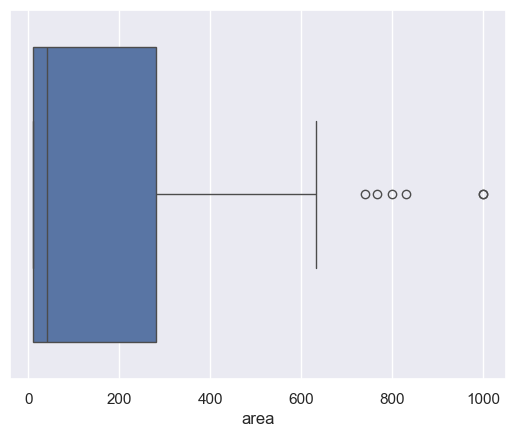

In [192]:
sns.boxplot(data=df.query('rooms == -2'), x='area')
plt.show()

По разбросу данных видно, что к студиям такие данные мы определить не можем. Другие объекты тоже имеют разную квадратура, поэтому точно соотнести их по категориям будет проблематично и скорее всего это будет через чур. Количество составляет менее 1%. Таким образом их можно просто извлечь из дальнейшего исследования.

In [10]:
df = df.query('rooms != -2')

Теперь посмотрим на такие признаки как price и связка level и levels. У меня есть подозрения, что цена может быть равна или быть меньше нуля, что будет являться странным явлением на рынке недвижимости. Также проверим гипотезу, где квартиры находятся выше количества этажей самого дома или ниже нуля. Такие ошибки можно списать на человеческий фактор, поэтому всегда стоит проверять данные на подготовительном этапе.

In [194]:
df.query('price <= 0')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date_month,reg_name,okrug
43821,-1633967296,2018-09-14,5520,1,13,22,1,38.92,NaN,11,2018-09-01,Пермский край,Приволжский
43822,-1633967296,2018-09-14,5520,1,14,22,1,38.92,17.26,11,2018-09-01,Пермский край,Приволжский
179212,0,2018-10-01,6817,3,5,10,3,104.00,15.00,1,2018-10-01,Алтайский край,Сибирский
199895,-429242296,2018-10-04,9654,2,5,25,2,57.27,9.31,11,2018-10-01,Новосибирская область,Сибирский
208483,-1744967296,2018-10-06,9654,3,4,5,2,45.00,6.00,1,2018-10-01,Новосибирская область,Сибирский
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382188,-2041757296,2021-04-23,2604,3,2,4,1,41.08,9.31,11,2021-04-01,Ярославская область,Центральный
5382595,-1794967296,2021-04-23,81,1,4,5,2,56.00,9.00,1,2021-04-01,Московская область,Центральный
5398253,-1494967296,2021-04-26,2843,3,3,3,1,45.00,17.00,11,2021-04-01,Краснодарский край,Южный
5419426,-2094967296,2021-04-27,3991,3,14,19,1,30.00,8.00,1,2021-04-01,Тюменская область,Уральский


In [195]:
df.query('level > levels')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date_month,reg_name,okrug
26283,1850000,2018-09-12,3870,3,17,13,1,37.00,10.00,1,2018-09-01,Красноярский край,Сибирский
35903,1100000,2018-09-13,9654,3,4,1,1,30.00,8.00,1,2018-09-01,Новосибирская область,Сибирский
117969,700000,2018-09-22,2722,3,2,1,2,40.00,11.00,1,2018-09-01,Республика Башкортостан,Приволжский
148751,3200000,2018-09-27,11171,2,4,3,1,31.00,10.00,1,2018-09-01,Республика Саха (Якутия),Дальневосточный
164863,1050000,2018-09-28,2843,4,2,1,2,54.00,10.00,1,2018-09-01,Краснодарский край,Южный
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942329,4750000,2021-01-19,2843,4,11,10,2,54.00,6.00,1,2021-01-01,Краснодарский край,Южный
5175158,6984180,2021-03-18,81,3,4,3,2,57.80,11.68,11,2021-03-01,Московская область,Центральный
5175162,7164620,2021-03-18,81,3,4,3,2,78.84,11.68,11,2021-03-01,Московская область,Центральный
5175971,4136487,2021-03-18,81,3,4,3,1,48.40,9.01,11,2021-03-01,Московская область,Центральный


In [9]:
df.query('level <= 0')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date_month,reg_name,okrug


Мы видим, что действительно существуют такие данные, которые выбиваются из логической картины рынка недвижимости. В данных присутствуют объекты с нулевой и отрицательной ценой. Стратегия по их устранению будет следующей: мы уберем их из исследования. Они не представляют собой огромную долю среди всех объектов, поэтому они не смогут сыграть большую роль в репрезентации остальных данных.<br>
Ситуация с этажами немного отличается. Нулевых этажей у нас в данных не оказалось, однако, некоторые объекты недвижимости оказались выше крыши собственных домов. Наглядная картина наличия человеческого фактора или системной ошибки. В данном случае мы можем поступить следующим образом: поменять значения этажей на последний этаж каждого дома. Будем считать, что превышение максимального числа этажей обусловлено ошибкой, а настоящее значение должно быть максимальным этажом каждого дома.

In [11]:
df = df.query('price > 0')

In [12]:
df['level'] = df.apply(lambda x: x['levels'] if x['level'] > x['levels'] else x['level'], axis=1)
df.query('level > levels')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,date_month,reg_name,okrug


Теперь можно перейти на числовые признаки, которые сложнее проанализировать из-за их непрерывной сущности.

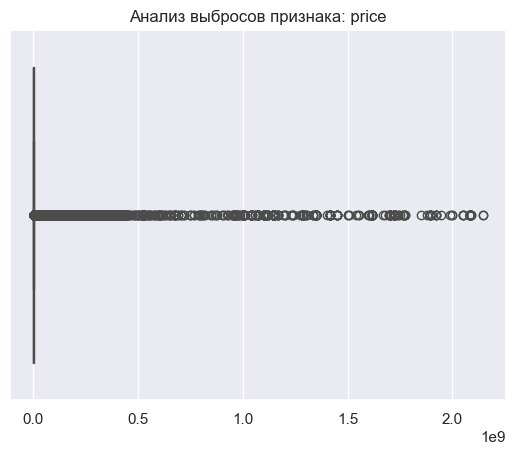

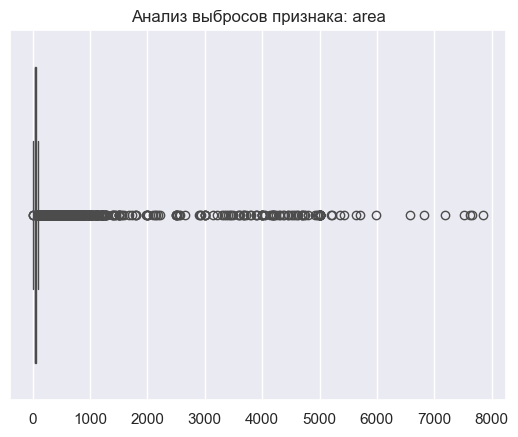

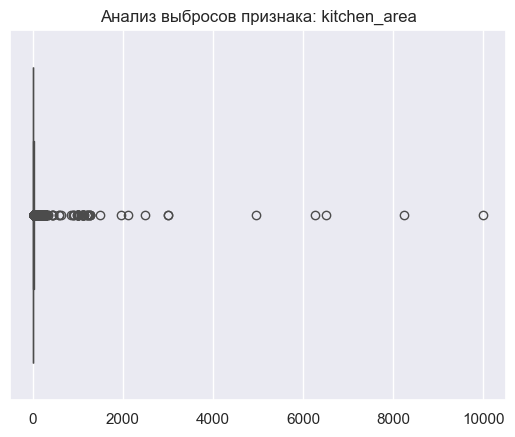

In [199]:
num_col_list = (df.select_dtypes(include=[np.number]).drop(columns=['region', 'building_type', 'object_type', 'level', 'levels', 'rooms'])
                .columns.tolist())

for i in num_col_list:
    plt.figure(i)
    plt.title(f'Анализ выбросов признака: {i}')
    sns.boxplot(data=df, x=i)

    plt.xlabel(None)
    plt.show()


По этим графикам можно сделать несколько выводов:
<ol>
    <li> Среди числовых признаков существуют такие как level, levels и rooms. Необходимость в обработке таких выбросов, кажется нецелесообразной. Поскольку на рынке недвижимости в разных регионах существуют разные объекты, которые описывают ситуацию в том или ином регионе. </li>
    <li> Ситуция с признаками price, area и kithen_are иная.  Некоторые объекты на рынке близкие к 2 млд рублей, явно являются нестандартным явлением и считаются предметом эксклюзивного предложения на рынке недвижимости. То же самое можно сказать и про площадь квартиры. В России зарегистрировна соиальная норма на семью составляет около 42 м<SUP>2</SUP>. Поэтому объекты, находящиеся выше этого пределе, тоже считаются нестандартными.  </li>
    <li> Несмотря на нынешнюю ситуацию на рынке недвижимости, некоторые выбросы явно должны быть ошибочными </li>
</ol>

In [13]:
# Воспользуемся модифицированной z-оценкой для удаления выбросов по столбцам price, area, kitchen_area
df1 = df.copy()


def z_mod(data):
    median = data.median()
    dev_median = data - (data.median())
    abs_dev_median = np.abs(dev_median)
    MAD = abs_dev_median.median()

    zmod = (0.6745 * (data - data.median())) / (MAD + 1e-5)

    return zmod

for i in ["price", "area", "kitchen_area"]:
    zmod = z_mod(df1[i])
    mask = (np.abs(zmod) > 3.5)
    df1 = df1[~mask]



In [14]:
count_out = df.shape[0] - df1.shape[0]
per_out = round(100 - df1.shape[0] / df.shape[0] *100, 2)

count_out1 = df_main.shape[0] - df1.shape[0]
per_out1 = round(100 - df1.shape[0] / df_main.shape[0] *100, 2)

print(f"Количество объектов недвижимости снизилось на {count_out} ед. ({per_out}%)")
print(f"Количество объектов недвижимости от исходного объема снизилось на {count_out1} ед. ({per_out1}%)")


Количество объектов недвижимости снизилось на 523311 ед. (9.56%)
Количество объектов недвижимости от исходного объема снизилось на 524042 ед. (9.57%)


## 1.2 Пропуски kitchen_area

In [202]:
df1.isna().sum()

price                 0
date                  0
region                0
building_type         0
level                 0
levels                0
rooms                 0
area                  0
kitchen_area     232114
object_type           0
date_month            0
reg_name              0
okrug                 0
dtype: int64

Для заполнения пропусков используем модель средние значения агрегированные по следующим столбцам: 'region', 'object_type', 'building_type', 'rooms'

In [15]:
features = ['region', 'object_type', 'building_type', 'rooms']
kitch_dict = df1.groupby(features).agg({'kitchen_area': 'mean'}).reset_index()



# Создание словаря для быстрого доступа
fill_dict = {(row['region'], row['object_type'], row['building_type'], row['rooms']): row['kitchen_area']
             for _, row in kitch_dict.iterrows()}

# Функция для заполнения NaN
def fill_kitchen_area(row):
    key = (row['region'], row['object_type'], row['building_type'], row['rooms'])
    return fill_dict.get(key, np.nan)  # Если комбинации нет, оставляем NaN

# Применение функции к df1
df1['kitchen_area_filled'] = df1.apply(
    lambda row: fill_kitchen_area(row) if pd.isna(row['kitchen_area']) else row['kitchen_area'],
    axis=1
)

In [16]:
df1.isna().sum()

price                       0
date                        0
region                      0
building_type               0
level                       0
levels                      0
rooms                       0
area                        0
kitchen_area           232114
object_type                 0
date_month                  0
reg_name                    0
okrug                       0
kitchen_area_filled        33
dtype: int64

Осталось 33 пропуска, у которых не нашлось совпадений по выбранным признакам. Так как их осталась небольшая часть, то извлечем их из дальнейшейго исследования.

In [17]:
df1.drop(columns=['kitchen_area'], inplace=True)
df1.dropna(inplace=True)
df1.rename(columns={'kitchen_area_filled': 'kitchen_area'}, inplace=True)

# 2. Исследование рынка недвижимости

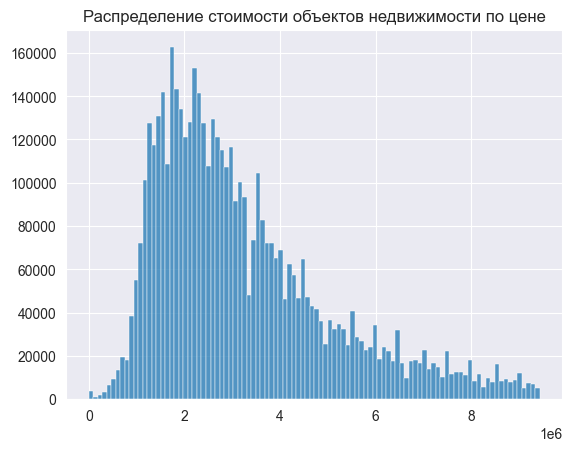

In [101]:
plt.title('Распределение стоимости объектов недвижимости по цене')
sns.histplot(data=df1, x='price', bins=100)
plt.xlabel(None)
plt.ylabel(None)

plt.show()

Распределение стоимости объектов недвижимости имеет выраженную правостороннюю асимметрию. Большинство объектов имеют стоимость до примерно 4 миллионов рублей, с пиком около 2 миллионов. Наличе длинного хвоста подтверждает наличие элитной недвижимости в диапазоне от 6 миллионов рублей.

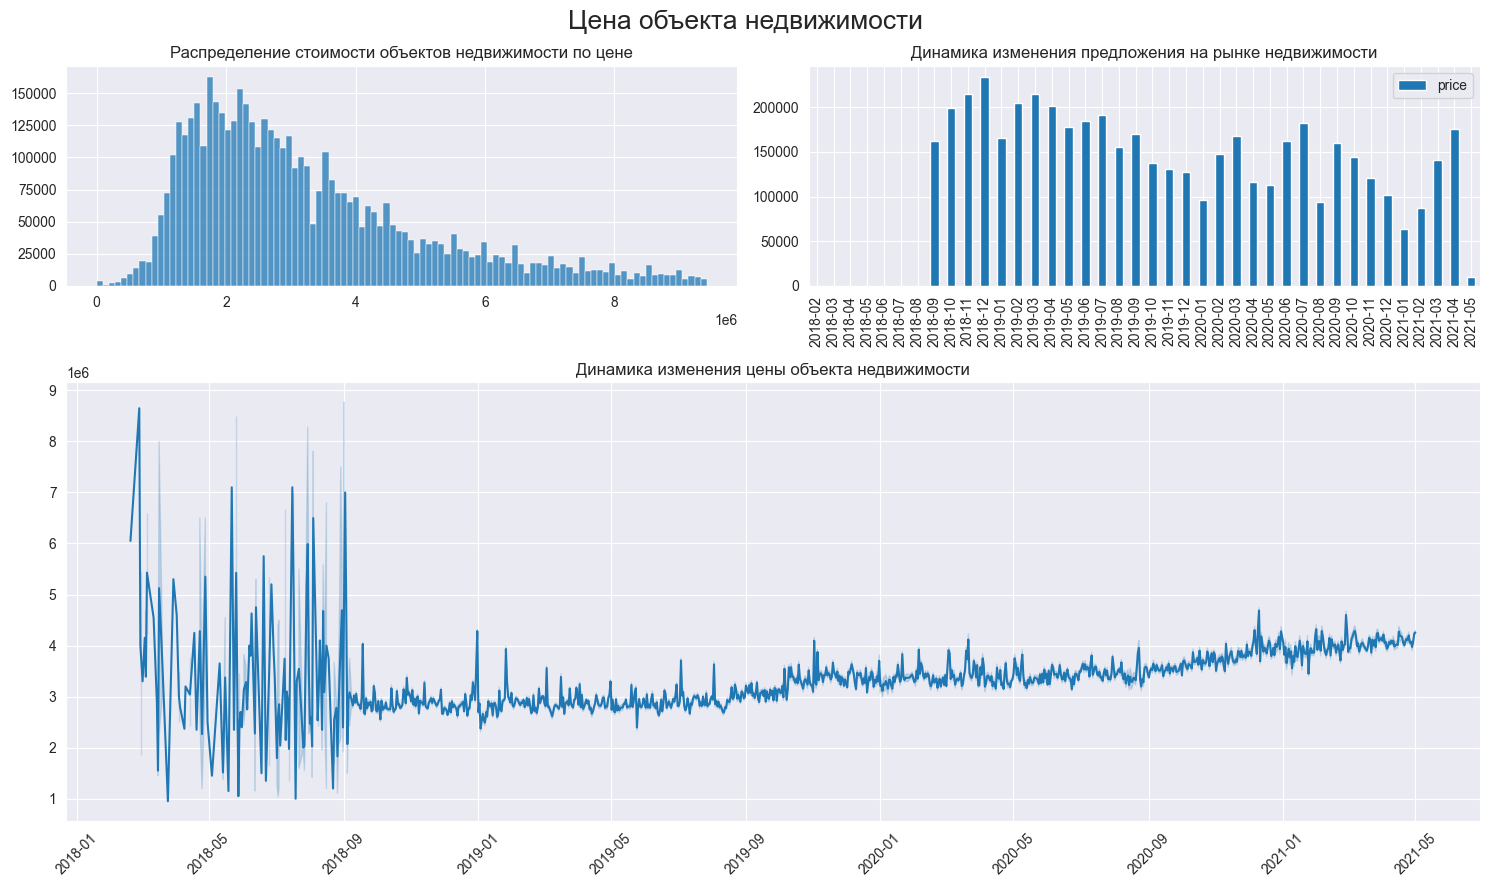

In [102]:
# Первый график: Количество объектов по месяцам

count_data = df1.groupby('date_month').agg({'price': 'count'}).reset_index()
# изменяем размер сетки
import matplotlib.gridspec as gridspec

plt.figure(figsize=[15, 9])
plt.suptitle('Цена объекта недвижимости', fontsize=19)

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])  # Первый ряд - 1 часть, второй - 2 части

# Гистограмма
plt.subplot(gs[0, 0])
sns.histplot(data=df1, x='price', bins=100)
plt.title('Распределение стоимости объектов недвижимости по цене')
plt.xlabel(None)
plt.ylabel(None)

# Столбчатая диаграмма
plt.subplot(gs[0, 1])
count_data.plot(kind='bar', x='date_month', y='price', ax=plt.gca())
plt.title('Динамика изменения предложения на рынке недвижимости')
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=90)

# Линейный график (занимает весь нижний ряд)
plt.subplot(gs[1, :])  # : охватывает оба столбца
sns.lineplot(data=df1, x='date', y='price', ax=plt.gca())
plt.title('Динамика изменения цены объекта недвижимости')
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel(None)

plt.tight_layout()
plt.show()


На основе этих графиков можно сделать, несколько выводов:
<ol>
    <li> Распределение стоимости объектов недвижимости имеет выраженную правостороннюю асимметрию. Большинство объектов имеют стоимость до примерно 4 миллионов рублей, с пиком около 2 миллионов. Наличие длинного хвоста подтверждает наличие элитной недвижимости в диапазоне от 6 миллионов рублей.
    <li> Предложение на рынке снижается. Причем это происходит происходит циклично. Также стоит отметить, что в первых 3 кварталах 2018 года представлено малое количество объектов недвижимости.
    <li> Рынок недвижимости пережил значительное снижение цен в 2018 году, затем стабилизацию и постепенный рост с 2020 года.
 <ol/>



Для дальнейшего исследования мы исключим некоторые данные: месяцы раньше сентября 2018 года и май 2021 года. Это решение обусловлено тем, что количество наблюдаемых объектов в эти периоды представляет малый процент выборки, а цены за такие объекты недвижимости являются крайне аномальными, что повредит исследованию рынка в целом.

In [19]:
df2 = df1.query('date > "2018-09-04" and date_month < "2021-05"')
df2['date_month'] = pd.to_datetime(df2['date_month'].dt.to_timestamp()).map(lambda x: x.replace(day=1))
df2.shape[0]

4942870

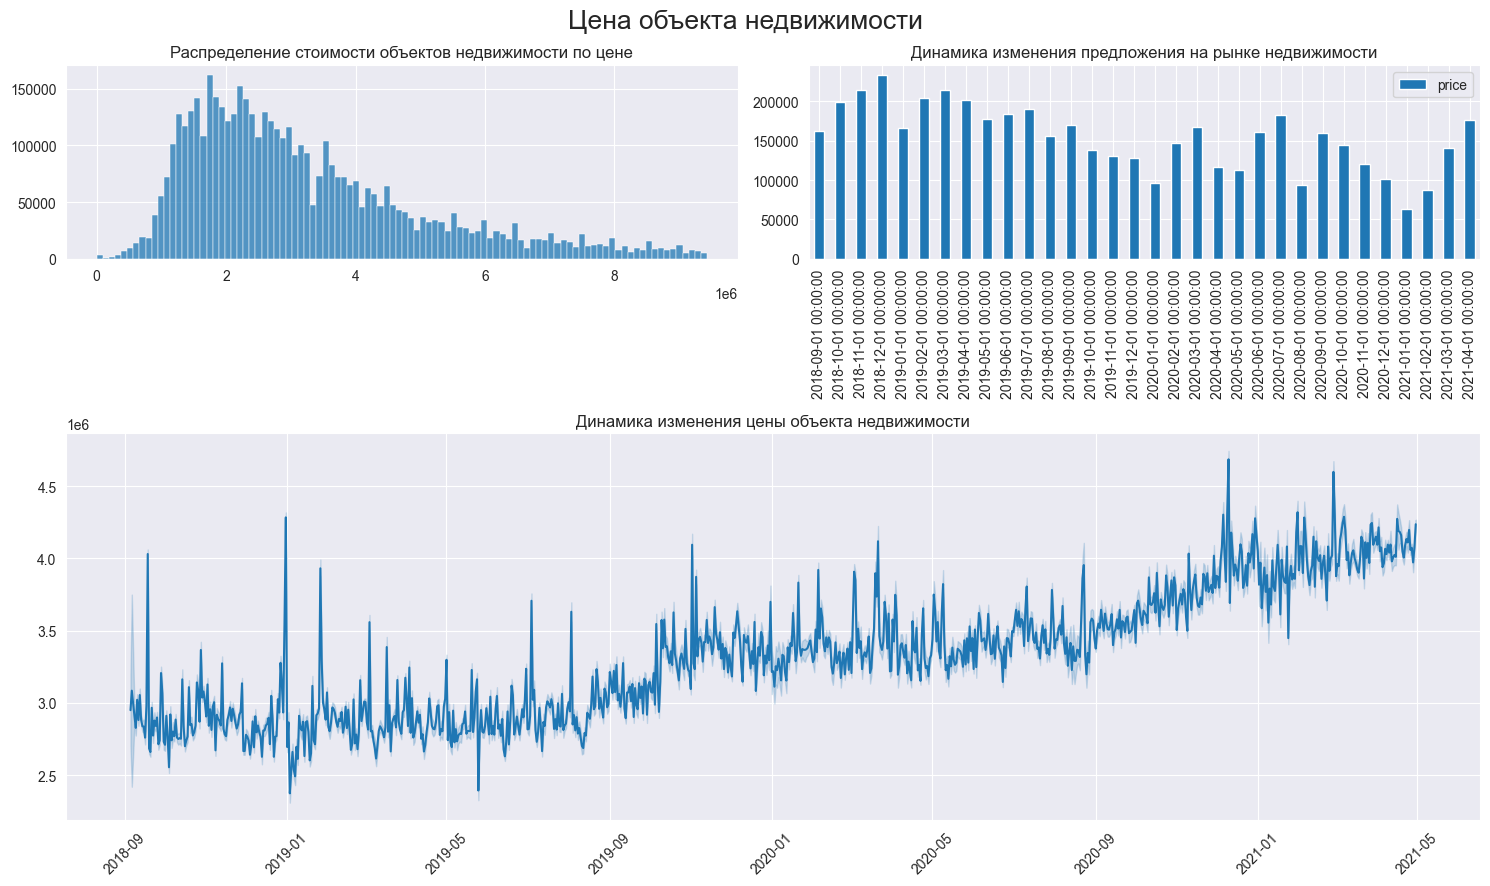

In [196]:
# Первый график: Количество объектов по месяцам

count_data = df2.groupby('date_month').agg({'price': 'count'}).reset_index()
# изменяем размер сетки
import matplotlib.gridspec as gridspec

plt.figure(figsize=[15, 9])
plt.suptitle('Цена объекта недвижимости', fontsize=19)

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2])  # Первый ряд - 1 часть, второй - 2 части

# Гистограмма
plt.subplot(gs[0, 0])
sns.histplot(data=df2, x='price', bins=100)
plt.title('Распределение стоимости объектов недвижимости по цене')
plt.xlabel(None)
plt.ylabel(None)

# Столбчатая диаграмма
plt.subplot(gs[0, 1])
count_data.plot(kind='bar', x='date_month', y='price', ax=plt.gca())
plt.title('Динамика изменения предложения на рынке недвижимости')
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=90)

# Линейный график (занимает весь нижний ряд)
plt.subplot(gs[1, :])  # : охватывает оба столбца
sns.lineplot(data=df2, x='date', y='price', ax=plt.gca())
plt.title('Динамика изменения цены объекта недвижимости')
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel(None)

plt.tight_layout()
plt.show()


Еще раз посмотрим на графики. Тенденции остались те же, но теперь отсутствует явная перекошенность по цене.

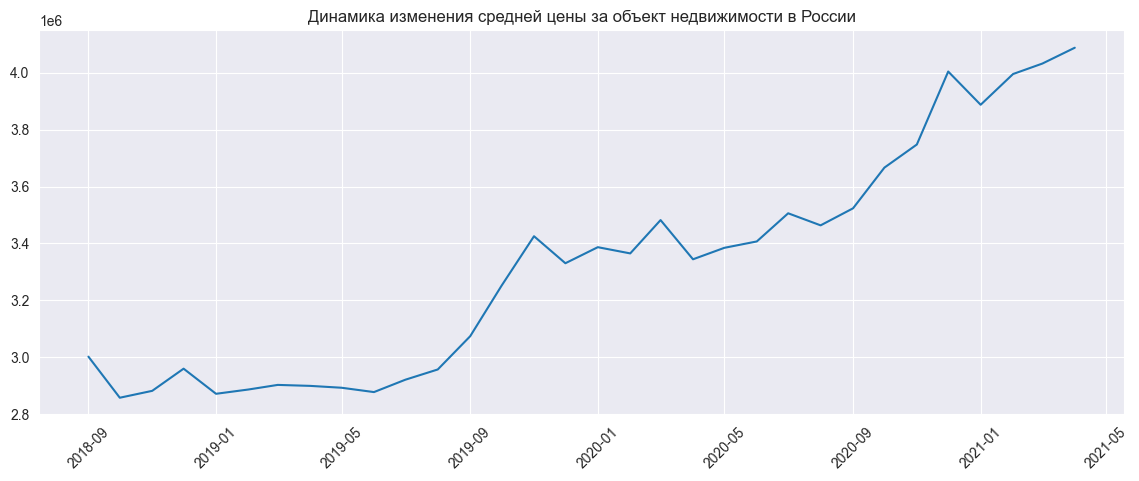

In [197]:
dyn_all = df2.groupby('date_month').agg({'price': 'mean'}).reset_index()
# dyn_all.plot(kind='line', x='date_month', y='price', figsize=(15, 5))
plt.figure(figsize=(14, 5))
plt.title('Динамика изменения средней цены за объект недвижимости в России')
sns.lineplot(data=dyn_all, x='date_month', y='price')

plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel(None)

plt.show()

На основе графика можно сделать вывод, что рынок недвижимости пережил значительное снижение цен в 2018 году, затем стабилизацию и постепенный рост с 2020 года.

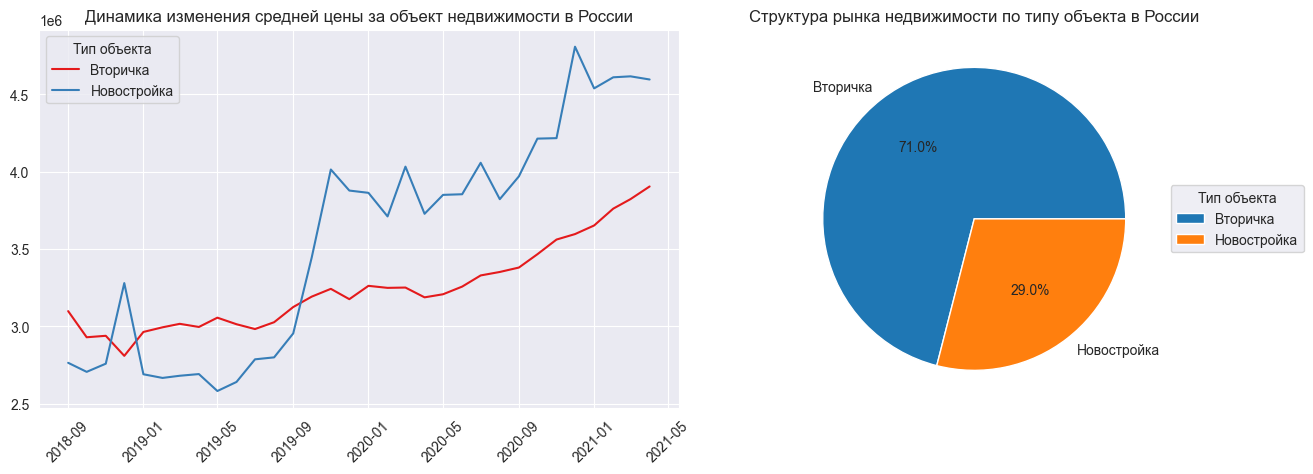

In [198]:
dyn_all_object = df2.groupby(['date_month', 'object_type']).agg({'price': 'mean'}).reset_index()
dyn_all_object['object_type'] = dyn_all_object['object_type'].map({1: 'Вторичка', 11: 'Новостройка'})
dyn_all_object_mean = df2.groupby(['object_type']).agg({'price': 'mean'}).reset_index()


count_object = df2.groupby(['object_type']).agg({'price': 'count'}).reset_index()
count_object['object_type'] = count_object['object_type'].map({1: 'Вторичка', 11: 'Новостройка'})


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Первый график: Динамика средней цены
palette = sns.color_palette('Set1', n_colors=2)
ax1.set_title('Динамика изменения средней цены за объект недвижимости в России')
sns.lineplot(data=dyn_all_object, x='date_month', y='price', hue='object_type', palette=palette, ax=ax1)
ax1.legend(title='Тип объекта')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel(None)
ax1.set_ylabel(None)

# Второй график: Структура рынка
ax2.set_title('Структура рынка недвижимости по типу объекта в России')
ax2.pie(count_object['price'], labels=count_object['object_type'],autopct='%1.1f%%')
ax2.legend(title='Тип объекта', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

# Убираем подписи осей для второго графика, если не нужны
ax2.set_xlabel(None)
ax2.set_ylabel(None)

# Настройка общего вида
plt.tight_layout()

# Показать графики
plt.show()

На основе графика можно сделать вывод, что новостройки демонстрируют более динамичный рост цен с 2020 года по сравнению с вторичным рынком, что может свидетельствовать о предпочтении покупателей новостроек или изменении рыночных условий, тогда как вторичка показывает более плавное восстановление.

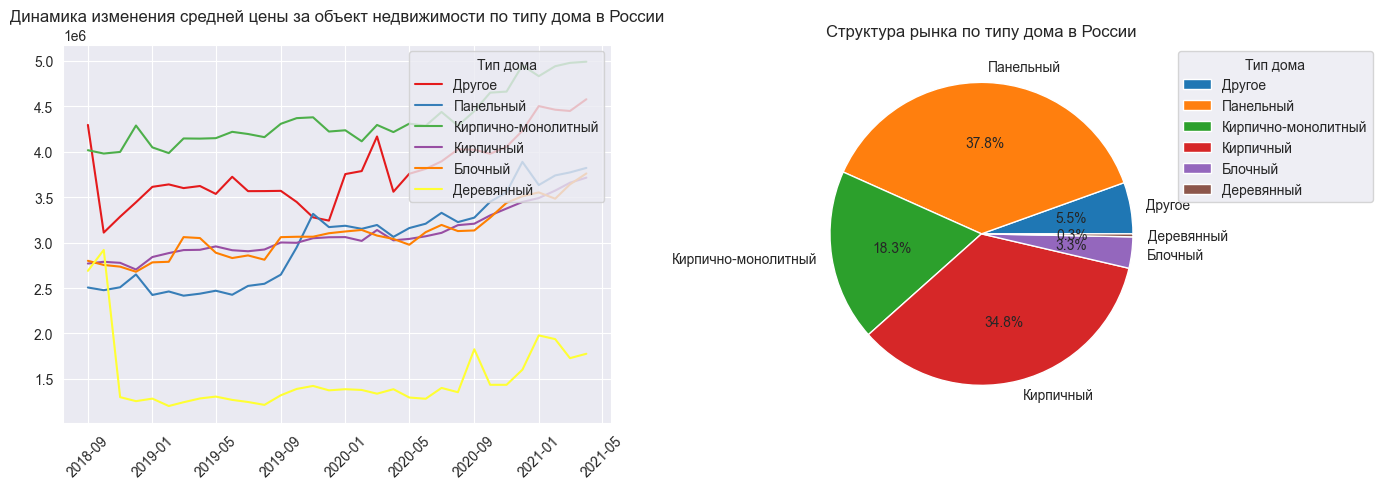

In [199]:
dyn_all_object = df2.groupby(['date_month', 'building_type']).agg({'price': 'mean'}).reset_index()
dyn_all_object['building_type'] = (dyn_all_object['building_type'].
                                   map({0: 'Другое', 1: 'Панельный', 2: 'Кирпично-монолитный', 3: 'Кирпичный', 4: 'Блочный', 5: 'Деревянный'}))

count_object = df2.groupby('building_type').agg({'price': 'count'}).reset_index()
count_object['building_type'] = count_object['building_type'].map({0: 'Другое', 1: 'Панельный', 2: 'Кирпично-монолитный', 3: 'Кирпичный', 4: 'Блочный', 5: 'Деревянный'})

# Создание фигуры с двумя подграфиками (слева и справа)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Первый график (слева): Динамика средней цены
palette = sns.color_palette('Set1', n_colors=6)
ax1.set_title('Динамика изменения средней цены за объект недвижимости по типу дома в России')
sns.lineplot(data=dyn_all_object, x='date_month', y='price', hue='building_type', palette=palette, ax=ax1)
ax1.legend(title='Тип дома', loc='upper right')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel(None)
ax1.set_ylabel(None)

# Второй график (справа): Структура рынка по типу дома
ax2.set_title('Структура рынка по типу дома в России')
ax2.pie(count_object['price'], labels=count_object['building_type'], autopct='%1.1f%%')
ax2.legend(title='Тип дома', loc='upper left', bbox_to_anchor=(1, 0, 0.5, 1))

# Убираем подписи осей для второго графика, если не нужны
ax2.set_xlabel(None)
ax2.set_ylabel(None)

# Настройка общего вида
plt.tight_layout()

# Показать графики
plt.show()


На основе графика можно сделать вывод, что "деревянные" и "другие" объекты недвижимости упали в цене и только в начале 2019 наметилась стабилизация цен с дальнейшим плавным ростом.  Деревянные постройки являются самыми дешевыми среди всех объектов недвижимости, самыми дорогими - кирпично-монолитные.<br>
Ны рынке недвижимость большую часть доли предложения занимают три типа домов: панельные (37.5%), кирпичные (34.8%), кирпично-монолитные (16.3%). Меньше всего представлены деревянные постройки (0.3%)

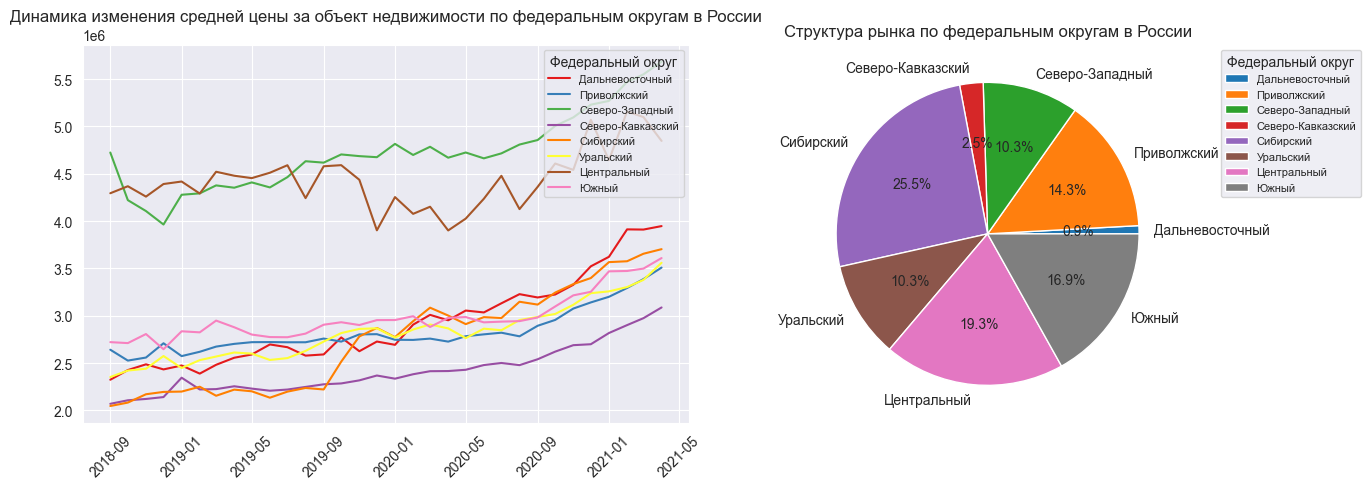

In [200]:
dyn_all_object = df2.groupby(['date_month', 'okrug']).agg({'price': 'mean'}).reset_index()

count_object = df2.groupby('okrug').agg({'price': 'count'}).reset_index()

# Создание фигуры с двумя подграфиками (слева и справа)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Первый график (слева): Динамика средней цены
palette = sns.color_palette('Set1', n_colors=8)  # 8 цветов для 8 федеральных округов
ax1.set_title('Динамика изменения средней цены за объект недвижимости по федеральным округам в России')
sns.lineplot(data=dyn_all_object, x='date_month', y='price', hue='okrug', palette=palette, ax=ax1)
ax1.legend(title='Федеральный округ', loc='upper right', prop={'size':8})
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel(None)
ax1.set_ylabel(None)

# Второй график (справа): Структура рынка по федеральным округам
ax2.set_title('Структура рынка по федеральным округам в России')
ax2.pie(count_object['price'], labels=count_object['okrug'], autopct='%1.1f%%',)
ax2.legend(title='Федеральный округ', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1), prop={'size':8})

# Убираем подписи осей для второго графика, если не нужны
ax2.set_xlabel(None)
ax2.set_ylabel(None)

# Настройка общего вида
plt.tight_layout()

# Показать графики
plt.show()

В сентябре 2018 года начинается плавный рост средней цены на недвижимость. Стоит отметить, что два федеральных округа имеют более высокие цены, чем другие: Северо-Западный и Центральный. Средние цены Северо-Западного федерального округа постепенно растут, в отличие от Центрального. Начиная с сентября 2019 средние цены Центрального федерального округа начинают колебаться до конца мая 2021 года.<br>
За весь наблюдаемый период больше всего объектов недвижимости имели три федеральных округа: Сибирский (25.5%), Центральный (19.3%) и Южный (16.9%). Меньше всего объектов недвижимости было представлено у Дальневосточного ФО (0.9%).

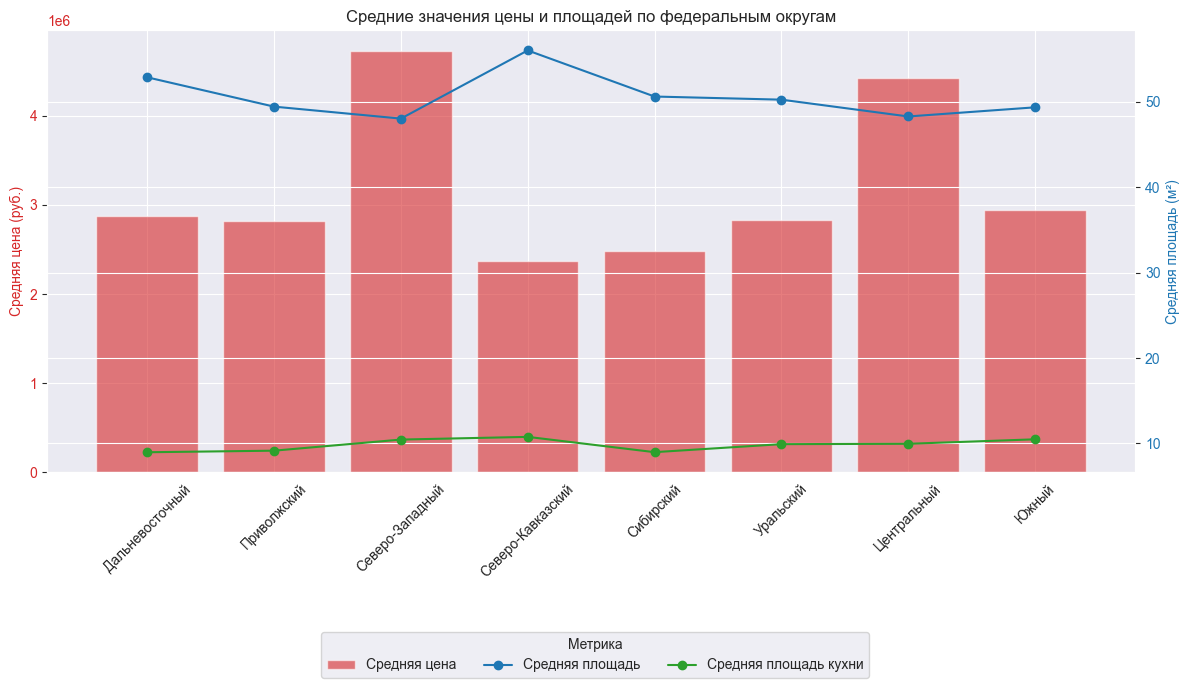

In [201]:
grouped_data = df2.groupby('okrug').agg({'price': 'mean', 'area': 'mean', 'kitchen_area': 'mean'}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title('Средние значения цены и площадей по федеральным округам')
ax1.set_xlabel(None)
ax1.set_ylabel('Средняя цена (руб.)', color='tab:red')
ax1.bar(grouped_data['okrug'], grouped_data['price'], color='tab:red', alpha=0.6, label='Средняя цена')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.set_ylabel('Средняя площадь (м²)', color='tab:blue')
ax2.plot(grouped_data['okrug'], grouped_data['area'], color='tab:blue', marker='o', label='Средняя площадь')
ax2.plot(grouped_data['okrug'], grouped_data['kitchen_area'], color='tab:green', marker='o', label='Средняя площадь кухни')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.legend(title='Метрика', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
fig.tight_layout()
plt.show()

На основе этого графика видно, что средняя цена за квадратные метры самая высокая в двух регионах: Северо-Западном и Центральном. В этих округах средний размер площади составляет около 50 квадратных метров. Стоимость такой недвижимости имеет цену размером около 4.5 млн рублей.

В других федеральных округах средняя цена колеблется от 2.5 до 2.9 млн рублей за площадь объекта размером 50 м2.

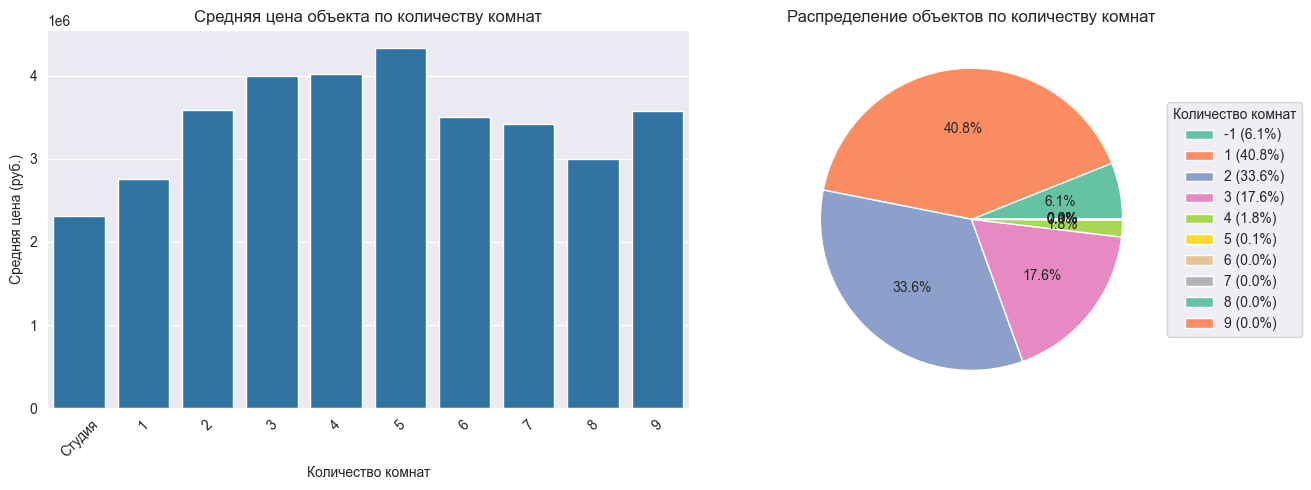

In [203]:
# Средняя цена по количеству комнат
price_by_rooms = df2.groupby('rooms')['price'].mean().reset_index()
price_by_rooms['rooms'] = price_by_rooms['rooms'].replace(-1, 'Студия')  # Заменяем -1 на "Студия"

# Количество объектов по количеству комнат
count_by_rooms = df2.groupby('rooms')['price'].count().reset_index()
count_by_rooms['rooms'] = count_by_rooms['rooms']  # Заменяем -1 на "Студия"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Первый график: Столбчатая диаграмма средней цены
ax1.set_title('Средняя цена объекта по количеству комнат')
sns.barplot(data=price_by_rooms, x='rooms', y='price', ax=ax1)
ax1.set_xlabel('Количество комнат')
ax1.set_ylabel('Средняя цена (руб.)')
ax1.tick_params(axis='x', rotation=45)

# Второй график: Круговая диаграмма количества объектов
ax2.set_title('Распределение объектов по количеству комнат')
wedges, texts, autotexts = ax2.pie(count_by_rooms['price'], labels=None, autopct='%1.1f%%', colors=sns.color_palette('Set2', len(count_by_rooms)))

# Создание кастомной легенды с процентами
legend_labels = [f'{label} ({autotext.get_text()})' for label, autotext in zip(count_by_rooms['rooms'], autotexts)]
ax2.legend(wedges, legend_labels, title='Количество комнат', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))


ax2.set_xlabel(None)
ax2.set_ylabel(None)


plt.tight_layout()

plt.show()

На основе этих графиков можно сказать, что на рынке недвижимости доминирует три объекта недвижимости, у которых одна (40.8%), две (33.6%) и три (17.6%) комнаты. В обратном порядке находятся средние цены по этим объектам: объекты с тремя комнатами имеют среднюю цену около 4 млн. рублей, с двумя комнатами - около 3.5 млн. рублей, с одной комнатой - около 2.8 млн. рублей. Самые дорогие объекты недвижимости это объекты с 5 комнатами. Их средняя цена составляет около 4.5 млн. рублей. Самые дешевые объекты это студии. Их средняя цена на рынке недвижимости равняется около 2.3 млн. рублей. Доля студий на рынке составляет около 6%.

In [205]:
# Также посмотри топ 5 самых дорогих регионов на рынке недвижимости по регионам и их площадь
df2.groupby('reg_name').agg({'price':'mean', 'area': 'mean'}).reset_index().sort_values(by='price', ascending=False).head(5)

,reg_name,price,area
29,Москва,6.682835e+06,41.451140
63,Санкт-Петербург,5.396887e+06,46.979927
1,Амурская область,4.429427e+06,53.031574
30,Московская область,4.379849e+06,49.243400
52,Республика Крым,4.323637e+06,52.845138


Самым дорогим регионом оказалась Москва, Санкт-Петербург, Амурская область, Московская область, Республика Крым. Во всех регионах средняя площадь недвижимости составляет околок 50 квадратных метров, только в Москве она составляет 41 квадратный метр. Средняя стоимость недвижимости в этих регионах составляет больше 4.3 млн рублей. Максимальный средняя цена у Москвы доходит почти до 7 млн рублей.

# 3.Когда выгодно покупать/продавать недвижимость?

Чтобы ответить на этот вопрос, давайте посмотрим на средние цены объектов по месяцам, убрав при этом тренд и лишний "шум".<br>
По графику средних цен выше мы уже видели, что данные похоже имеют аддитивную природу, поэтому будем декомпозировать данные, основываясь на этом предположении.

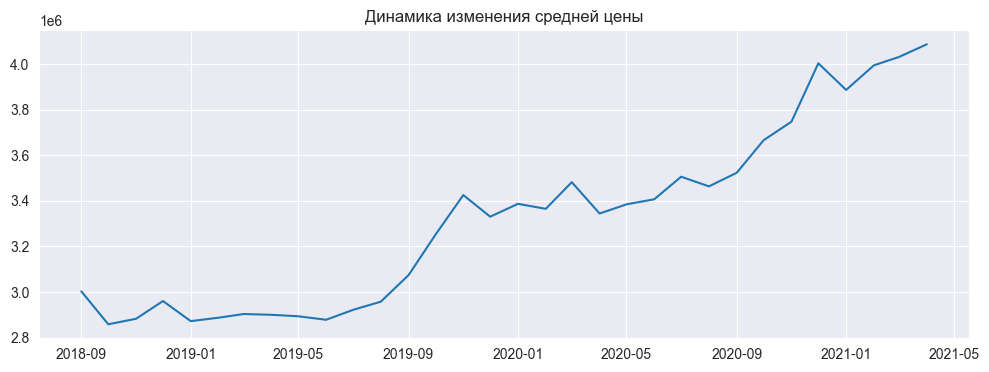

In [218]:
from statsmodels.tsa.seasonal import seasonal_decompose


group_mean = df2.groupby('date_month').agg({'price':'mean'}).reset_index()
# group_mean = df2[['date', 'price']]

plt.figure(figsize=(12, 4))
plt.title('Динамика изменения средней цены')
sns.lineplot(data=group_mean, x='date_month', y='price')
plt.ylabel(None)
plt.xlabel(None)
plt.show()

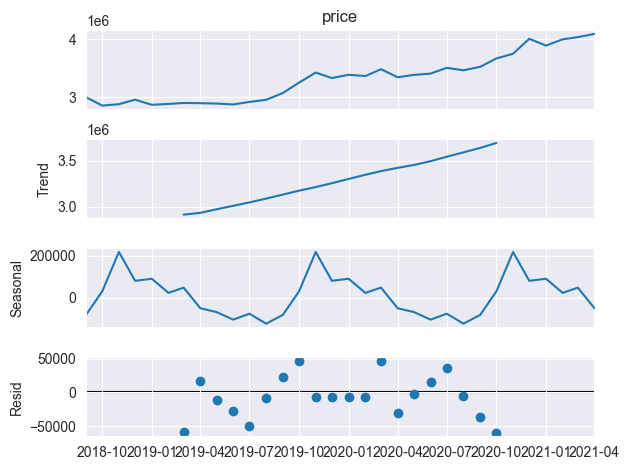

In [219]:
group_mean.set_index('date_month', inplace=True)

decompose_result = seasonal_decompose(group_mean['price'], model="additive", period=12)

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot()
plt.show()

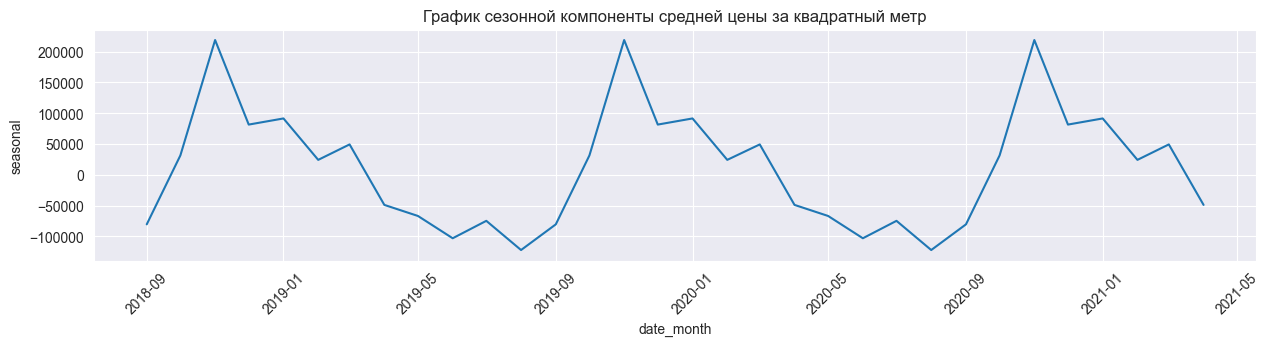

In [220]:
plt.figure(figsize=(15, 3))
plt.title('График сезонной компоненты средней цены за квадратный метр')
sns.lineplot(x=group_mean.index, y=seasonal)
plt.xticks(rotation=45)
plt.show()

Анализируя сезонную компоненты, мы можем наблюдать, что крайние значения имеют август (минимум) и ноябрь (максимум). Именно в эти месяцы стоит покупать и продавать объекты недвижимости с максимальной выгодой. Взглянув еще раз на общий график, можно сказать, что это предположение подтверждается, поскольку и там мы наблюдаем такую картину, что после августа цена растет, а после ноября цена падает.

# 4. Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.

Для начала построим корреляционную матрицу и посмотрим корреляцию между признаками.

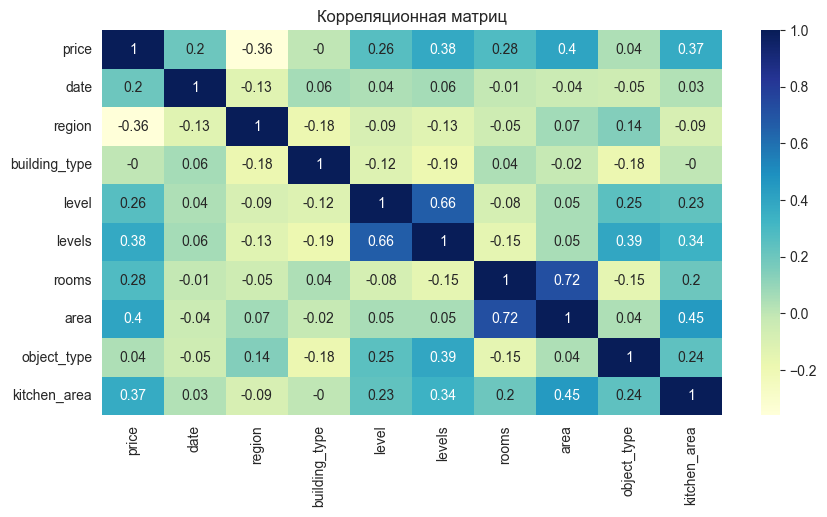

In [243]:
corr = df2.drop(columns=['date_month', 'reg_name', 'okrug']).corr().round(2)

plt.figure(figsize=(10, 5))

plt.title('Корреляционная матриц')
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

На основе корреляционной матрицы, мы видим, что цена объекта больше всего коррелирует со следующими признаками:
<ol>
    <li>дата
    <li>регион
    <li>этаж
    <li>этажность дома
    <li>количество комнат
    <li>площадь квартиры
    <li>площадь кухни
</ol>
Некоторые из этих признаков мы уже анализировали. Рассмотрим детальнее как этаж влияет на среднюю цену объекта.

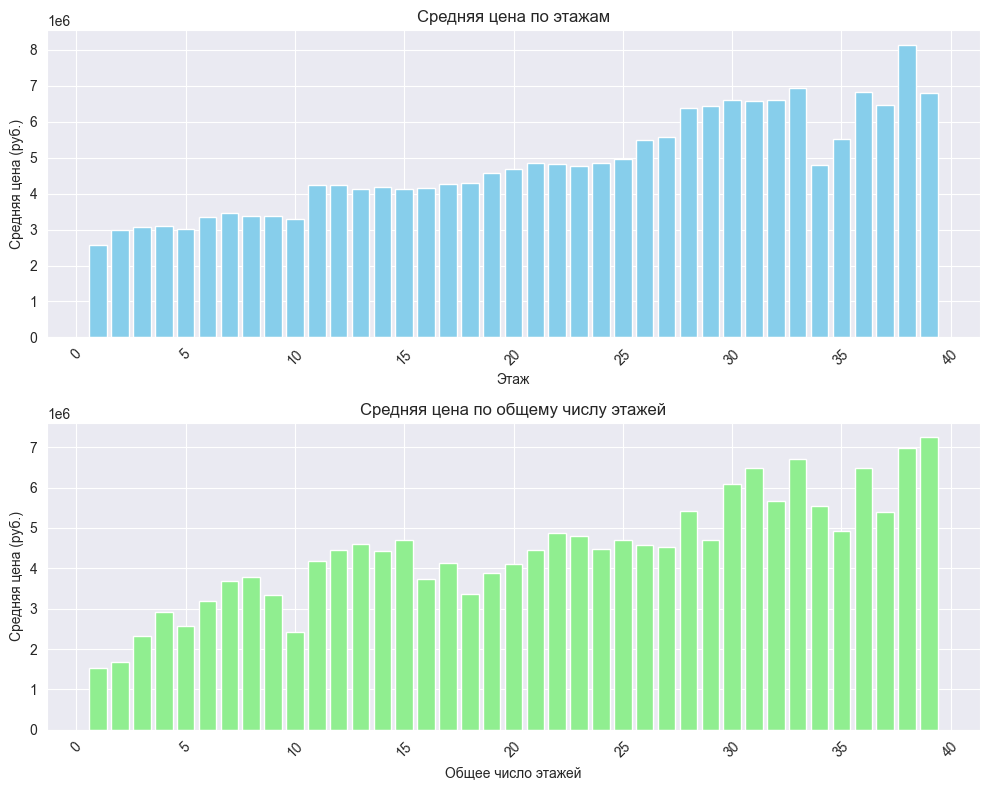

In [223]:
df_group_level = df2.groupby('level').agg({'price': 'mean'}).reset_index()
df_group_levels = df2.groupby('levels').agg({'price': 'mean'}).reset_index()

# Создание фигуры с двумя подграфиками (2 ряда, 1 столбец)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Первый график: Средняя цена по этажам (level)
ax1.bar(x=df_group_level['level'], height=df_group_level['price'], color='skyblue')
ax1.set_title('Средняя цена по этажам')
ax1.set_xlabel('Этаж')
ax1.set_ylabel('Средняя цена (руб.)')
ax1.tick_params(axis='x', rotation=45)

# Второй график: Средняя цена по общему числу этажей (levels)
ax2.bar(x=df_group_levels['levels'], height=df_group_levels['price'], color='lightgreen')
ax2.set_title('Средняя цена по общему числу этажей')
ax2.set_xlabel('Общее число этажей')
ax2.set_ylabel('Средняя цена (руб.)')
ax2.tick_params(axis='x', rotation=45)

# Настройка общего вида
plt.tight_layout()

# Показать графики
plt.show()

На основе этих графиков можно утверждать, что с ростом этажности и этажа объекта недвижимости, цена в среднем растет.<br>
Небольшое падение можно наблюдать в районе 35 этажа. Также стоит отметить, что дома с количеством этажей около 10, 17 и 35 имеют среднюю цену ниже за квадратные метры, чем те, которые находятся рядом с ними. Это может быть обусловлено тем, что это старые дома, либо новые дома бюджетного класса.

# 5. Собственная гипотеза

Проверим, влияет ли тип дома в Центральном федеральном округе на цену объекта недвижимости<br>
H0: Средняя цена за объект недвижимости (price) для типов домов (building_type) одинакова в Центральном федеральном округе.<br>
H1: Средняя цена различается между типами домов в Центральном федеральном округе.<br>

In [80]:
# так как мы сравниваем несколько групп, не зная их распределение, то воспользуемся методом Welch ANOVA.
import pingouin as pg

central = df2[df2['okrug'] == 'Центральный'].dropna()

data_long = central.melt(id_vars=['building_type'], value_vars=['price'], var_name='variable', value_name='value')
result = pg.welch_anova(data=data_long, dv='value', between='building_type')
if result['p-unc'][0] < 0.05:
    print("Отвергаем H0: средние цены различаются.")

Отвергаем H0: средние цены различаются.


# 6. Построение предсказательной модели

Будем предсказывать цену за квадратный метр для упрощения. Это поможет нормализовать разницу площади между объектами и приведет наши значения к общей практике сравнения цены квадратного метра на рынке недвижимости.

In [20]:
df2['price_metr'] = df2['price'] / df2['area']

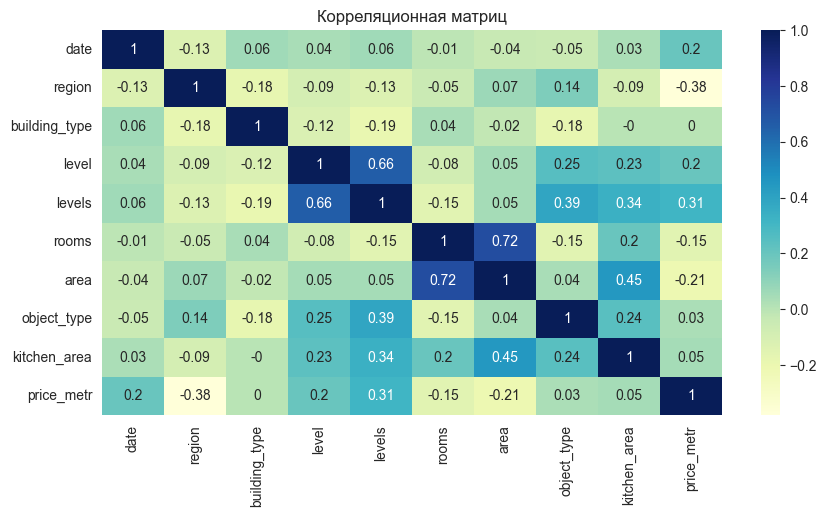

In [22]:
corr = df2.drop(columns=['date_month', 'reg_name', 'okrug', 'price']).corr().round(2)

plt.figure(figsize=(10, 5))

plt.title('Корреляционная матриц')
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

На основе корреляционной матрицы, мы видим, что цена за квадратный метр больше всего коррелирует со следующими признаками:
<ol>
    <li>дата
    <li>регион
    <li>этаж
    <li>этажность дома
    <li>количество комнат
    <li>площадь квартиры
    <li>площадь кухни
</ol>
Некоторые признаки коррелируют между собой: level и levels, area и kitchen_area. Удалим level и kitchen_area, так как корреляция с price меньше.<br>
Также выделим год и месяц отдельно.

In [29]:
ML_df = df2.drop(columns=['reg_name', 'okrug', 'price','level','kitchen_area','date_month', 'building_type', 'object_type'])
ML_df['year'] =ML_df.date.dt.year
ML_df['month'] =ML_df.date.dt.month
ML_df.drop(columns=['date'], inplace=True)
ML_df = pd.get_dummies(ML_df, columns=['region', 'levels'])

In [57]:
X = ML_df.drop(columns=['price_metr'])
y = ML_df['price_metr']


X = StandardScaler().fit_transform(X)


X_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False, test_size=0.2)


# модели
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

elas_model = ElasticNet(alpha=10)
elas_model.fit(X_train, y_train)

xbr_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, n_jobs=-1)
xbr_model.fit(X_train, y_train)

lightgbm_model = LGBMRegressor(random_state=0, n_estimators=300, learning_rate=0.1, max_depth=3, n_jobs=-1)
lightgbm_model.fit(X_train, y_train)

cat_model = CatBoostRegressor(random_state=0, learning_rate=0.1, iterations=1000, logging_level='Silent')
cat_model.fit(X_train, y_train)


# Предсказания
xbr_pred = xbr_model.predict(x_test)
lin_pred = lin_model.predict(x_test)
elas_pred = elas_model.predict(x_test)
lightgbm_pred = lightgbm_model.predict(x_test)
cat_pred = cat_model.predict(x_test)

models = ['XGBoost', 'Linear', 'ElasticNet', 'LightGBM', 'CatBoost']
pred = [xbr_pred, lin_pred, elas_pred, lightgbm_pred, cat_pred]
rmse_list = [root_mean_squared_error(y_test, i) for i in pred]
r2_list = [r2_score(y_test, i) for i in pred]

#результаты
models_results = pd.DataFrame({'model': models, 'RMSE': rmse_list, 'R2': r2_list})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 3954296, number of used features: 125
[LightGBM] [Info] Start training from score 64818.202215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [82]:
models_results.sort_values(by='RMSE')

,model,RMSE,R2
4,CatBoost,26708.765151,0.683348
3,LightGBM,28956.681982,0.627803
1,Linear,28998.345560,0.626732
0,XGBoost,29122.287597,0.623534
2,ElasticNet,45601.786529,0.076922


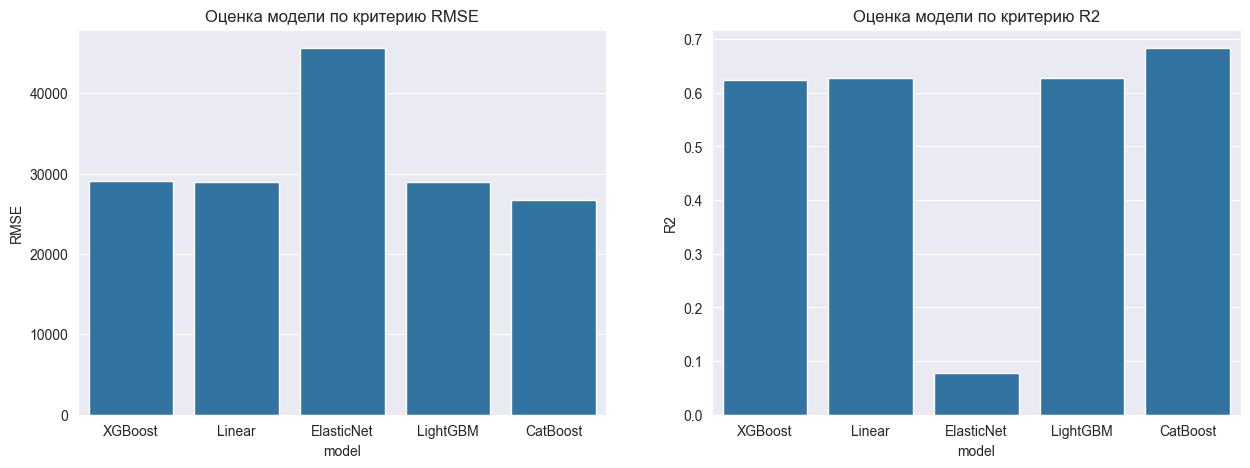

In [78]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Оценка модели по критерию RMSE')
sns.barplot(data=models_results, x='model', y='RMSE')


plt.subplot(1, 2, 2)
plt.title('Оценка модели по критерию R2')
sns.barplot(data=models_results, x='model', y='R2')


plt.show()

На основе построенных моделей для предсказания цены объекта недвижимости оказалась модель CatBoost. Значение по оценке RMSE равно 26_708, а по R2 составило 68%.